In [1]:
from transformers import BertTokenizer, AdamW, get_linear_schedule_with_warmup, BertForSequenceClassification
import torch
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 8, 5
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

c:\Users\DeboraOrsolich\miniconda3\envs\ques_gen_env\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import json
with open("cls_dataset.json") as f:
    dataset = json.load(f)

with open("results_distilbert_base_cased_2022-05-25_1653492425.4573438.json") as f:
    train_results = json.load(f)

with open("test_results_distilbert_base_cased_2022-05-25_1653492628.4043052.json") as f:
    val_results = json.load(f)

In [3]:
df_train = pd.DataFrame.from_dict(dataset["train"])
# df_val = pd.DataFrame.from_dict(dataset["val"])
df_test = pd.DataFrame.from_dict(dataset["test"])
frames = [df_train, df_test]
df = pd.concat(frames)
i = 1
print(df.shape)
df.head()

(5636, 2)


text  labels
0  certainly , many algorithms are built complex ...       1
1  but what i would like to ask - what are the al...       1
2           is it just based on the length of code ?       0
3  is tere a way to solve a math problem with alg...       1
4                        could dna be an algorithm ?       1

In [7]:
ax = sns.countplot(df.labels)
ax.set_title("Dataset labels")
class_names = ['Not useful for learning', 'Useful for learning']
plt.xlabel('labels')
ax.set_xticklabels(class_names)

c:\Users\DeboraOrsolich\miniconda3\envs\ques_gen_env\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


[Text(0, 0, 'Not useful for learning'), Text(1, 0, 'Useful for learning')]

In [8]:
ax = sns.countplot(df_train.labels)
ax.set_title("Training set labels")
class_names = ['Not useful for learning', 'Useful for learning']
plt.xlabel('labels in train set')
ax.set_xticklabels(class_names)

c:\Users\DeboraOrsolich\miniconda3\envs\ques_gen_env\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


[Text(0, 0, 'Not useful for learning'), Text(1, 0, 'Useful for learning')]

c:\Users\DeboraOrsolich\miniconda3\envs\ques_gen_env\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


[Text(0, 0, 'Not useful for learning'), Text(1, 0, 'Useful for learning')]

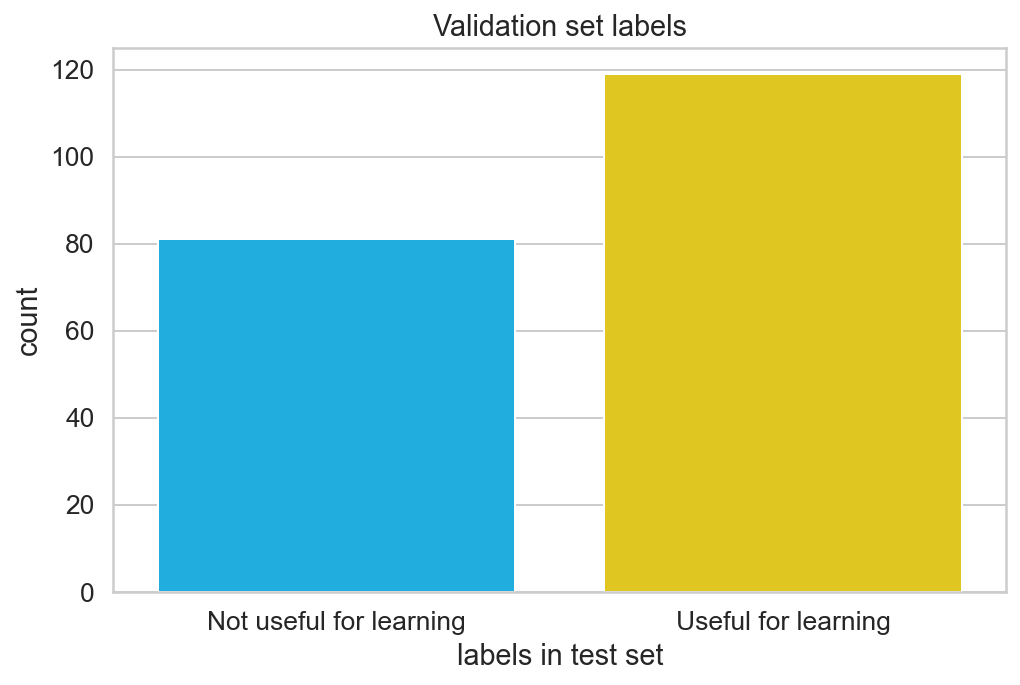

In [9]:
ax = sns.countplot(df_test.labels)
ax.set_title("Validation set labels")
class_names = ['Not useful for learning', 'Useful for learning']
plt.xlabel('labels in test set')
ax.set_xticklabels(class_names)

In [10]:
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

sample_txt = dataset["train"]["text"][0]
tokens = tokenizer.tokenize(sample_txt)
token_ids = tokenizer.convert_tokens_to_ids(tokens)
print(f' Sentence: \n{sample_txt}')
print(f'   Tokens: \n{tokens}')
print(f'Token IDs: \n{token_ids}')
print(f"SEP token \n{tokenizer.sep_token}, \nsep_token_id {tokenizer.sep_token_id}")
print(f"CLS token \n{tokenizer.cls_token}, \ncls_token_id {tokenizer.cls_token_id}")
print(f"PAD token \n{tokenizer.pad_token}, \npad_token_id {tokenizer.pad_token_id}")
print(f"UNK token \n{tokenizer.unk_token}, \nunk_token_id {tokenizer.unk_token_id}")

 Sentence: 
certainly , many algorithms are built complex and efficient by combining many algorithms into one ( as one step may also be considered an algorithm , is n't it ?
   Tokens: 
['certainly', ',', 'many', 'algorithms', 'are', 'built', 'complex', 'and', 'efficient', 'by', 'combining', 'many', 'algorithms', 'into', 'one', '(', 'as', 'one', 'step', 'may', 'also', 'be', 'considered', 'an', 'algorithm', ',', 'is', 'n', "'", 't', 'it', '?']
Token IDs: 
[4664, 117, 1242, 14975, 1132, 1434, 2703, 1105, 7856, 1118, 12459, 1242, 14975, 1154, 1141, 113, 1112, 1141, 2585, 1336, 1145, 1129, 1737, 1126, 9932, 117, 1110, 183, 112, 189, 1122, 136]
SEP token 
[SEP], 
sep_token_id 102
CLS token 
[CLS], 
cls_token_id 101
PAD token 
[PAD], 
pad_token_id 0
UNK token 
[UNK], 
unk_token_id 100


In [11]:
encoding = tokenizer.encode_plus(
  sample_txt,
  max_length=32,
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',  # Return PyTorch tensors
)
print(encoding.keys())
print(len(encoding['input_ids'][0]), encoding['input_ids'][0])
print(len(encoding['attention_mask'][0]), encoding['attention_mask'][0])
print(tokenizer.convert_ids_to_tokens(encoding['input_ids'][0]))


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


dict_keys(['input_ids', 'attention_mask'])
32 tensor([  101,  4664,   117,  1242, 14975,  1132,  1434,  2703,  1105,  7856,
         1118, 12459,  1242, 14975,  1154,  1141,   113,  1112,  1141,  2585,
         1336,  1145,  1129,  1737,  1126,  9932,   117,  1110,   183,   112,
          189,   102])
32 tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1])
['[CLS]', 'certainly', ',', 'many', 'algorithms', 'are', 'built', 'complex', 'and', 'efficient', 'by', 'combining', 'many', 'algorithms', 'into', 'one', '(', 'as', 'one', 'step', 'may', 'also', 'be', 'considered', 'an', 'algorithm', ',', 'is', 'n', "'", 't', '[SEP]']


c:\Users\DeboraOrsolich\miniconda3\envs\ques_gen_env\lib\site-packages\transformers\tokenization_utils_base.py:2251: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


c:\Users\DeboraOrsolich\miniconda3\envs\ques_gen_env\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 0, 'Token count')

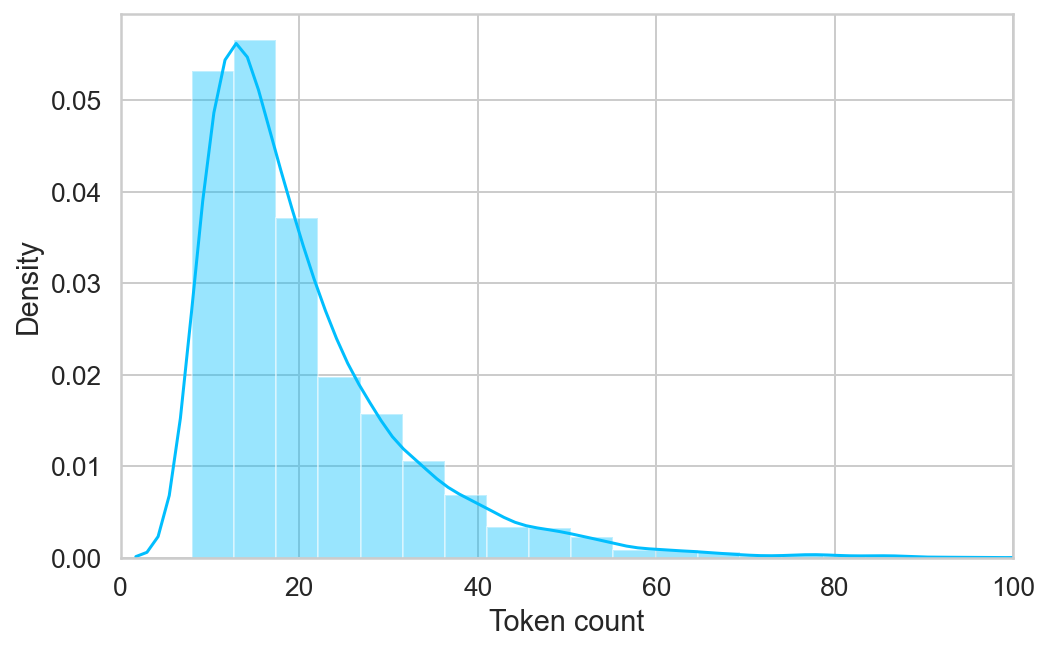

In [12]:
token_lens = []
for txt in df.text:
  tokens = tokenizer.encode(txt, max_length=512)
  token_lens.append(len(tokens))

sns.distplot(token_lens)
plt.xlim([0, 100])
plt.xlabel('Token count')

In [13]:
print(train_results.keys())
print()
print(val_results.keys())

dict_keys(['device', 'len_dataset', 'example_context', 'example_question', 'seed', 'test', 'dataset', 'dataset_split', 'model', 'model_name', 'learning_rate', 'adam_epsilon', 'batch_size', 'n_epochs', 'lr_decay', 'dropout', 'max_length_source', 'max_length_target', 'epoch_loss_values', 'batch_loss_values', 'epoch_training_time', 'total_training_time', 'epochs_avg_loss_values', 'pred_y', 'true_y', 'epoch_total_loss', 'validation_loss', 'score'])

dict_keys(['device', 'len_dataset', 'example_context', 'example_question', 'seed', 'test', 'results_folder', 'dataset', 'dataset_split', 'model', 'model_name', 'batch_size', 'n_epochs', 'max_length_source', 'max_length_target', 'batch_loss_values', 'epochs_avg_loss_values', 'pred_y', 'true_y', 'epoch_total_loss', 'validation_loss', 'score'])


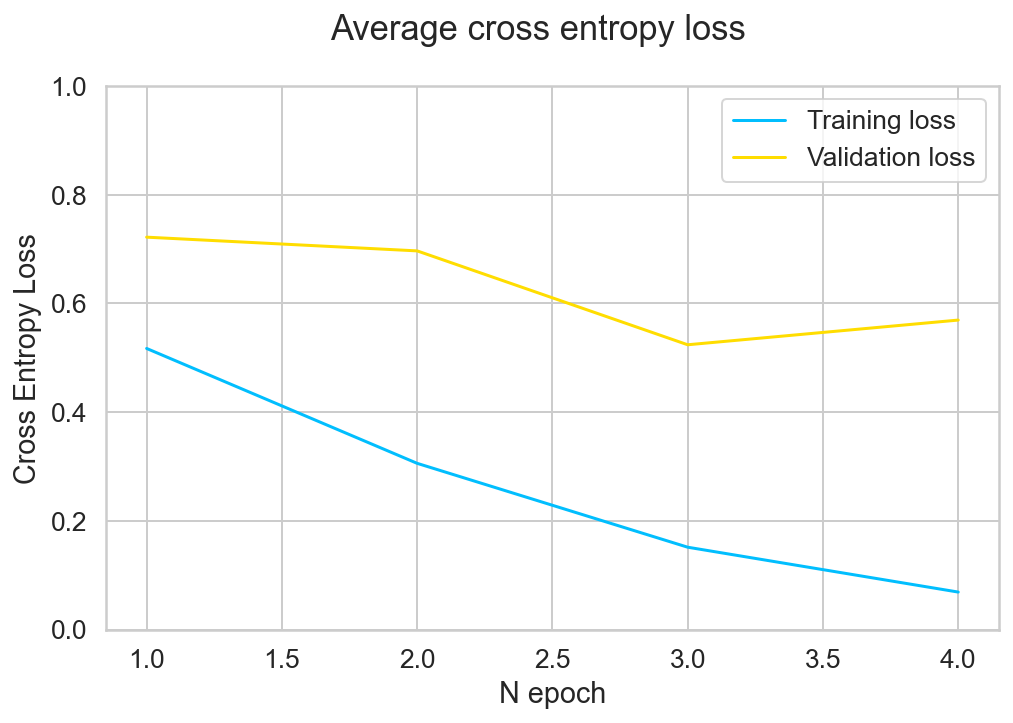

In [15]:
train_epoch_loss = train_results["epoch_loss_values"]
val_epoch_loss = val_results["epochs_avg_loss_values"]
# batch_loss_values = 
epoch = [i for i in range(1, 5)]
# sns.lineplot(x=epoch, y=train_epoch_loss)
plt.plot(epoch, train_epoch_loss, label="Training loss")
plt.plot(epoch, val_epoch_loss, label="Validation loss")
plt.suptitle("Average cross entropy loss")
plt.xlabel('N epoch')
plt.ylabel('Cross Entropy Loss')
plt.ylim([0, 1])
plt.legend()

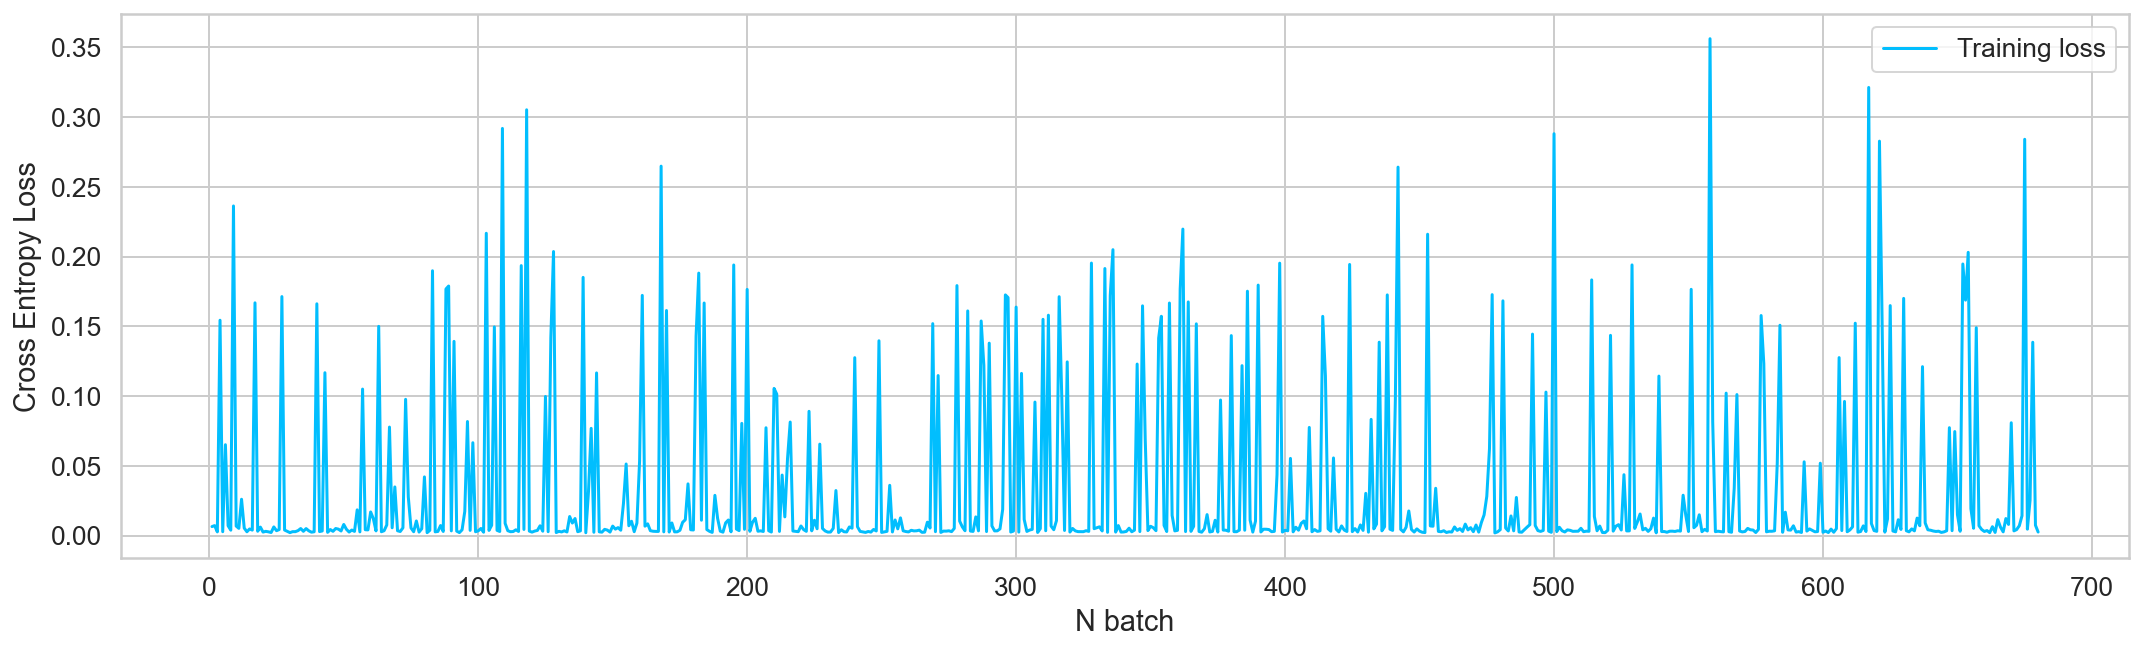

In [18]:
rcParams['figure.figsize'] = 18, 5
train_batch_loss = train_results["batch_loss_values"]
batch = [i for i in range(1, len(train_batch_loss)+1)]
sns.lineplot(x=batch, y=train_batch_loss, label="Training loss")
# plt.suptitle("Cross entropy loss")
plt.xlabel('N batch')
plt.ylabel('Cross Entropy Loss')
plt.legend()

In [19]:
rcParams['figure.figsize'] = 10, 5
val_batch_loss = val_results["batch_loss_values"]
batch = [i for i in range(1, len(val_batch_loss)+1)]
sns.lineplot(x=batch, y=val_batch_loss, label="Validation loss")
plt.xlabel('N batch')
plt.ylabel('Cross Entropy Loss')
plt.legend()

In [20]:
train_ys = {
    "true_y": train_results["true_y"],
    "pred_y": train_results["pred_y"],
}
val_ys = {
    "true_y": val_results["true_y"],
    "pred_y": val_results["pred_y"],
}
t_ys_df = df.from_dict(train_ys)
v_ys_df = df.from_dict(val_ys)

c:\Users\DeboraOrsolich\miniconda3\envs\ques_gen_env\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
c:\Users\DeboraOrsolich\miniconda3\envs\ques_gen_env\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\DeboraOrsolich\AppData\Local\Temp\ipykernel_11072\2045155307.py:8: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


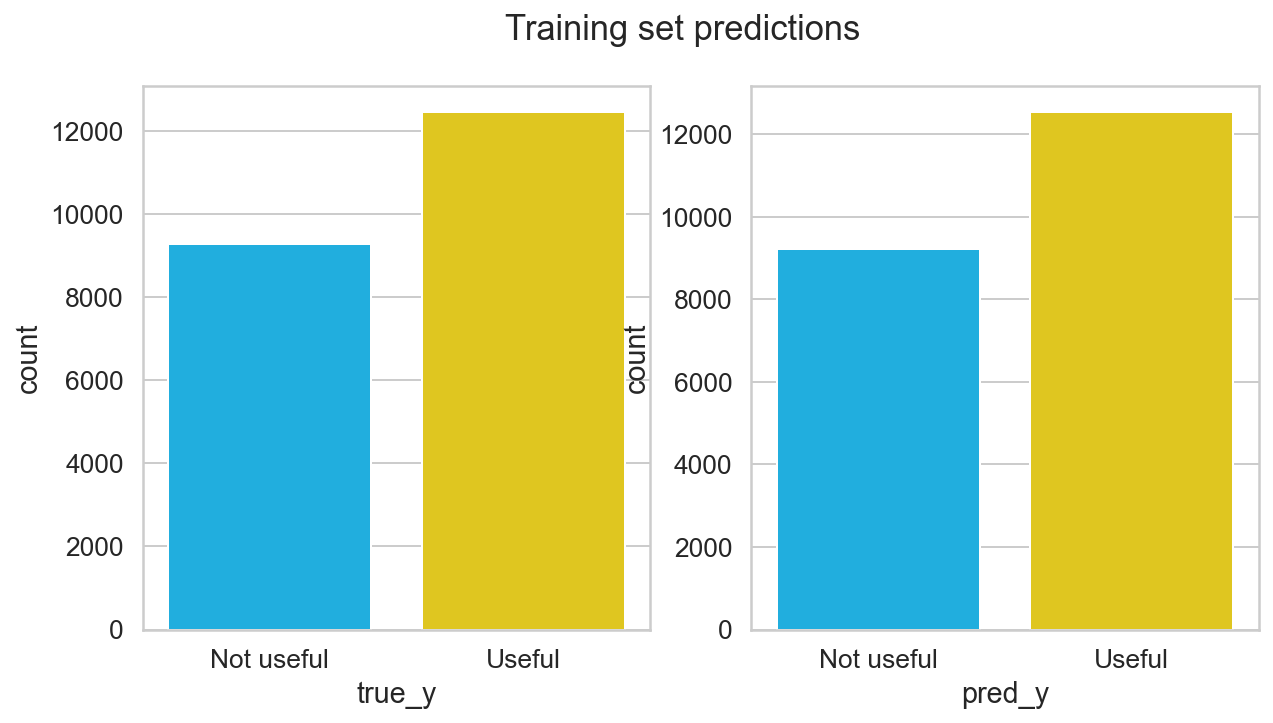

In [21]:
fig, ax =plt.subplots(1,2)
fig.suptitle("Training set predictions")
class_names = ['Not useful', 'Useful']
sns.countplot(t_ys_df['true_y'], ax=ax[0])
sns.countplot(t_ys_df['pred_y'], ax=ax[1])
ax[0].set_xticklabels(class_names)
ax[1].set_xticklabels(class_names)
fig.show()

In [22]:
fig, ax =plt.subplots(1,2)
fig.suptitle("Validation set predictions")
class_names = ['Not useful', 'Useful']
sns.countplot(v_ys_df['true_y'], ax=ax[0])
sns.countplot(v_ys_df['pred_y'], ax=ax[1])
ax[0].set_xticklabels(class_names)
ax[1].set_xticklabels(class_names)
fig.show()

c:\Users\DeboraOrsolich\miniconda3\envs\ques_gen_env\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
c:\Users\DeboraOrsolich\miniconda3\envs\ques_gen_env\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\DeboraOrsolich\AppData\Local\Temp\ipykernel_11072\599222541.py:8: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


In [29]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score
train_cf = confusion_matrix(train_results["true_y"], train_results["pred_y"])
train_accuracy = accuracy_score(train_results["true_y"], train_results["pred_y"])
train_recall = recall_score(train_results["true_y"], train_results["pred_y"], average=None)
train_precision = precision_score(train_results["true_y"], train_results["pred_y"], average=None)


val_cf = confusion_matrix(val_results["true_y"], val_results["pred_y"])
val_accuracy = accuracy_score(val_results["true_y"], val_results["pred_y"])
val_recall = recall_score(val_results["true_y"], val_results["pred_y"], average=None)
val_precision = precision_score(val_results["true_y"], val_results["pred_y"], average=None)

print("train_cf:    \n{}".format(train_cf))
print("train_accuracy:     {}".format(train_accuracy))
print("train_recall:       {}".format(train_recall))
print("train_precision:    {}".format(train_precision))

print()

print("val_cf:     \n{}".format(val_cf))
print("val_accuracy:       {}".format(val_accuracy))
print("val_recall:         {}".format(val_recall))
print("val_precision:      {}".format(val_precision))

train_cf:    
[[ 9160   124]
 [   48 12412]]
train_accuracy:     0.9920897718910964
train_recall:       [0.98664369 0.99614767]
train_precision:    [0.99478714 0.99010849]

val_cf:     
[[260  64]
 [ 40 436]]
val_accuracy:       0.87
val_recall:         [0.80246914 0.91596639]
val_precision:      [0.86666667 0.872     ]


In [33]:
from sklearn.metrics import classification_report
print("Training set:")
print(classification_report(train_results["true_y"], train_results["pred_y"], target_names=["Not useful", "useful"]))
print()
print("Validation set:")
print(classification_report(val_results["true_y"], val_results["pred_y"], target_names=["Not useful", "useful"]))


Training set:
              precision    recall  f1-score   support

  Not useful       0.99      0.99      0.99      9284
      useful       0.99      1.00      0.99     12460

    accuracy                           0.99     21744
   macro avg       0.99      0.99      0.99     21744
weighted avg       0.99      0.99      0.99     21744


Validation set:
              precision    recall  f1-score   support

  Not useful       0.87      0.80      0.83       324
      useful       0.87      0.92      0.89       476

    accuracy                           0.87       800
   macro avg       0.87      0.86      0.86       800
weighted avg       0.87      0.87      0.87       800



In [43]:

fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(train_cf, cmap=plt.cm.Blues, alpha=0.3)
for i in range(train_cf.shape[0]):
    for j in range(train_cf.shape[1]):
        ax.text(x=j, y=i,s=train_cf[i, j], va='center', ha='center', size='large')
 
plt.xlabel('Predictions', fontsize=12)
plt.ylabel('Actuals', fontsize=12)
plt.title('Training Set Confusion Matrix', fontsize=12)
plt.show()

In [50]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(val_cf, cmap=plt.cm.Blues, alpha=0.3)
for i in range(val_cf.shape[0]):
    for j in range(val_cf.shape[1]):
        ax.text(x=j, y=i,s=val_cf[i, j], va='center', ha='center', size='large')
 
plt.xlabel('Predictions', fontsize=12)
plt.ylabel('Actuals', fontsize=12)
plt.title('Validation Set Confusion Matrix', fontsize=12)
plt.show()